In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random,os
from numpy.random import rand
from numpy.random import randn
from random import shuffle
import pandas as pd
from scipy import signal
import scipy.signal
import librosa
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib nbagg

/Users/giacomo/opt/anaconda3/envs/torch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-07-10 11:15:42.387687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/giacomo/opt/anaconda3/envs/torch/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/giacomo/opt/anaconda3/envs/torch/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["dlopen

## Introduction

This notebook applies some useful methods to check the performance of the GAN model used to generate Fake spectrograms of residuals 

### Some useful functions

In [ ]:
def Spectrogram(Time, Data,fs): 
    f, t, Sxx = signal.spectrogram(Data, fs,nperseg=120)
    return f,t,Sxx

def frequency_time_residuals(Spectr,original_shape,n_fftW,save_flag,save_name=None,save_path=None):
    """
    Parameters
    ----------
       Spectr: spectrogram
       original_shape: shape of the time-series
       n_fftW: the window length of the STFT (https://librosa.org/doc/main/generated/librosa.griffinlim.html)
       save_flag: bolean, if True save the image
       save_name: name of the file to save
       save_path: path where save the file 
    Returns
    ----------
    

    """
    
    fontsizeT=17
    labelsizeT=12
    colors=pl.cm.spring(np.linspace(0,1,5))
    # Set up the axes with gridspec
    fig = plt.figure(figsize=(9, 7))
    grid = plt.GridSpec(4, 4, hspace=0, wspace=0)
    main_ax = fig.add_subplot(grid[:-1, 1:])
    y_sub = fig.add_subplot(grid[:-1, 0], sharey=main_ax)
    x_sub = fig.add_subplot(grid[-1, 1:])
   
    reverse=librosa.griffinlim(Spectr,win_length=n_fftW-2)
    f,t,Sx=Spectrogram(original_shape, reverse,fs=1)
    im=main_ax.pcolormesh(t,f,Sx,shading='gouraud',cmap='plasma',vmin=Sx.min(),vmax=Sx.max())
    main_ax.set_xticklabels([])
    main_ax.set_yticklabels([])
   
    #main_ax.set_yticklabels([])
    f,  w = scipy.signal.welch(reverse, fs=1,nperseg=200)
    y_sub.plot(w,f,color='k',linewidth=3)
    y_sub.invert_xaxis()
    y_sub.yaxis.set_tick_params(labelsize=labelsizeT)
    y_sub.xaxis.set_tick_params(labelsize=labelsizeT)
    y_sub.xaxis.set_tick_params(labelsize=labelsizeT,rotation=90)
    y_sub.set_xlabel( r'Power $[\frac{mm^2}{days^{-1}}]$', style='italic',fontsize=fontsizeT)
    y_sub.axhline(y=1/(365/2),color=colors[0],linewidth=2,label=r' 1 year')
    y_sub.axhline(y=1/(365/4),color=colors[1],linewidth=2,label=r' 0.5 year')
    y_sub.axhline(y=1/(60/2),color=colors[2],linewidth=2,label=r' 60 days')
    y_sub.axhline(y=1/(30/2),color=colors[3],linewidth=2,label=r' 30 days')
    y_sub.legend(loc='upper left',fontsize=labelsizeT)
   
    ax2 = y_sub.secondary_yaxis("left")
    ax2.yaxis.set_tick_params(labelsize=labelsizeT)
    ax2.set_ylabel('Frequency $[days^{-1}] $',fontsize=fontsizeT, style='italic')
    ax2.grid( which='both', color='0.65', linestyle='-',linewidth=0.1)
    y_sub.grid( which='both', color='0.65', linestyle='-',linewidth=0.1)
   
    x_sub.scatter(range(len(reverse)),reverse,s=20,c='grey',edgecolors='k',linewidths=0.3)
    x_sub.set_xlim(0,len(reverse))
    x_sub.xaxis.set_tick_params(labelsize=labelsizeT)
    x_sub.set_yticklabels([])
    x_sub.set_yticks([])
    axsub = x_sub.secondary_yaxis("right")
    axsub.yaxis.set_tick_params(labelsize=labelsizeT)
    axsub.set_ylabel('Displacement [mm]',fontsize=fontsizeT, style='italic')
    x_sub.set_xlabel('Time [days]',fontsize=fontsizeT, style='italic')

    cbar_ax = fig.add_axes([0.905, 0.306, 0.02, 0.575])
    cbar=fig.colorbar(im, cax=cbar_ax)
    cbar.ax.set_ylabel(r'Power $[\frac{mm^2}{days^{-1}}]$', style='italic',fontsize=fontsizeT)
    cbar.ax.tick_params(labelsize=labelsizeT)
    print(len(reverse))
    if save_flag==True:
        plt.savefig(+str(save_name))
    return plt.show()

def plot_confusion_matrix(cm_list,
                          target_names,
                          title,
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    
    figure,axes=plt.subplots(1,3,figsize=(15, 6))
    figure.subplots_adjust(wspace=0.4,hspace=0.2)
    
    ii=0
    for cm in cm_list:
        accuracy = np.trace(cm) / np.sum(cm).astype('float')
        misclass = 1 - accuracy

        if cmap is None:
            cmap = plt.get_cmap('Blues')

    
        im=axes[ii].imshow(cm, interpolation='nearest', cmap=cmap)
        axes[ii].set_title(title[ii])

        if target_names is not None:
            tick_marks = np.arange(len(target_names[ii]))
            axes[ii].set_xticks(tick_marks, target_names[ii], rotation=45)
            #if ii==0:
            axes[ii].set_yticks(tick_marks, target_names[ii])
            #else:
            #   axes[ii].set_yticks(tick_marks)
            #   axes[ii].yaxis.set_ticklabels([])

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                axes[ii].text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            else:
                axes[ii].text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        if ii==0:
            axes[ii].set_ylabel('True label')
        axes[ii].set_xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
        ii+=1
        
    cbar_ax = figure.add_axes([0.92, 0.23, 0.02, 0.53])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()
    #fig.tight_layout()
    return 

### Create datasets

In [9]:
#################### IMPORT DATA ####################
# SET A DATASET

cd_saving='/Users/giacomo/Downloads/Generated_spectrograms/'
print(cd_saving)

############ Set the components ############
components=['U/'] ################### solo U 'E/','N/' #E_N

############ Build the tensor 
years=3                                    # E_N_Residuals_ #
R_Residuals=np.load(cd_saving+components[0]+'U_Residuals_'+str(years)+'years.npy')  #U_Residuals
R_Residuals=np.vstack(np.transpose(R_Residuals,[2,0,1]))

### shuffle ###
idx = np.random.permutation(len(R_Residuals))
R_Residuals = np.asarray(R_Residuals)[idx]

############ Random data ############
n=np.array(R_Residuals).shape[1]
Std=np.array(R_Residuals).std()
Mean=np.array(R_Residuals).mean() 
random_input = Std*randn(np.array(R_Residuals).shape[0]* n) + Mean
random_input=np.reshape(random_input,(np.array(R_Residuals).shape[0],np.array(R_Residuals).shape[1]))
random_input2 = Std*randn(np.array(R_Residuals).shape[0]* n) + Mean
random_input2=np.reshape(random_input2,(np.array(R_Residuals).shape[0],np.array(R_Residuals).shape[1]))
print('Real data shape: ',R_Residuals.shape)
print('Random data shape: ',random_input.shape)

#################### Compute PSD ####################

Sxx=[] #real method 1
SxxI=[] #real for training
S_RT=[] #random 1
S_RT2=[] #random 2
n_fftW=94

fs=1
Time=R_Residuals.shape[1]
for jj in range(R_Residuals.shape[0]):
    f,t,Sx=Spectrogram(Time,  R_Residuals[jj,:],fs)
    S = np.abs(librosa.stft(R_Residuals[jj,:],n_fft=n_fftW))
    S=np.expand_dims(S,axis=1)
    S=np.array(tf.image.resize(S, (S.shape[0],S.shape[1])))
    S=np.squeeze(S)
    '''
    Sx=np.expand_dims(Sx,axis=1)
    Sx=np.array(tf.image.resize(Sx, (Sx.shape[0]-1,Sx.shape[1])))
    Sx=np.squeeze(Sx)
    '''
    Sxx.append(Sx)
    SxxI.append(S)
    S_R = np.abs(librosa.stft(random_input[jj,:],n_fft=n_fftW))
    S_R=np.expand_dims(S_R,axis=1)
    S_R=np.array(tf.image.resize(S_R, (S_R.shape[0],S_R.shape[1])))
    S_R=np.squeeze(S_R)
    S_RT.append(S_R)
    
    S_R2 = np.abs(librosa.stft(random_input2[jj,:],n_fft=n_fftW))
    S_R2=np.expand_dims(S_R2,axis=1)
    S_R2=np.array(tf.image.resize(S_R2, (S_R2.shape[0],S_R2.shape[1])))
    S_R2=np.squeeze(S_R2)
    S_RT2.append(S_R2)
    
    
Sxx=np.array(Sxx)
SxxI=np.array(SxxI)
S_RT=np.array(S_RT)
S_RT2=np.array(S_RT2)
print(Sxx.shape)
print('Data for training shape: ',SxxI.shape)
print('Random data shape: ',S_RT.shape)
print('Random data 2 shape: ',S_RT2.shape)

SxxI=(SxxI-SxxI.min())/(SxxI.max()-SxxI.min())
S_RT=(S_RT-SxxI.min())/(SxxI.max()-SxxI.min())
S_RT2=(S_RT2-SxxI.min())/(SxxI.max()-SxxI.min())
print('Finished')

/Users/giacomo/Downloads/Generated_spectrograms/
Real data shape:  (8070, 1095)
Random data shape:  (8070, 1095)
(8070, 61, 10)
Data for training shape:  (8070, 48, 48)
Random data shape:  (8070, 48, 48)
Random data 2 shape:  (8070, 48, 48)
Finished


### Plot the cumulative PSD

<IPython.core.display.Javascript object>


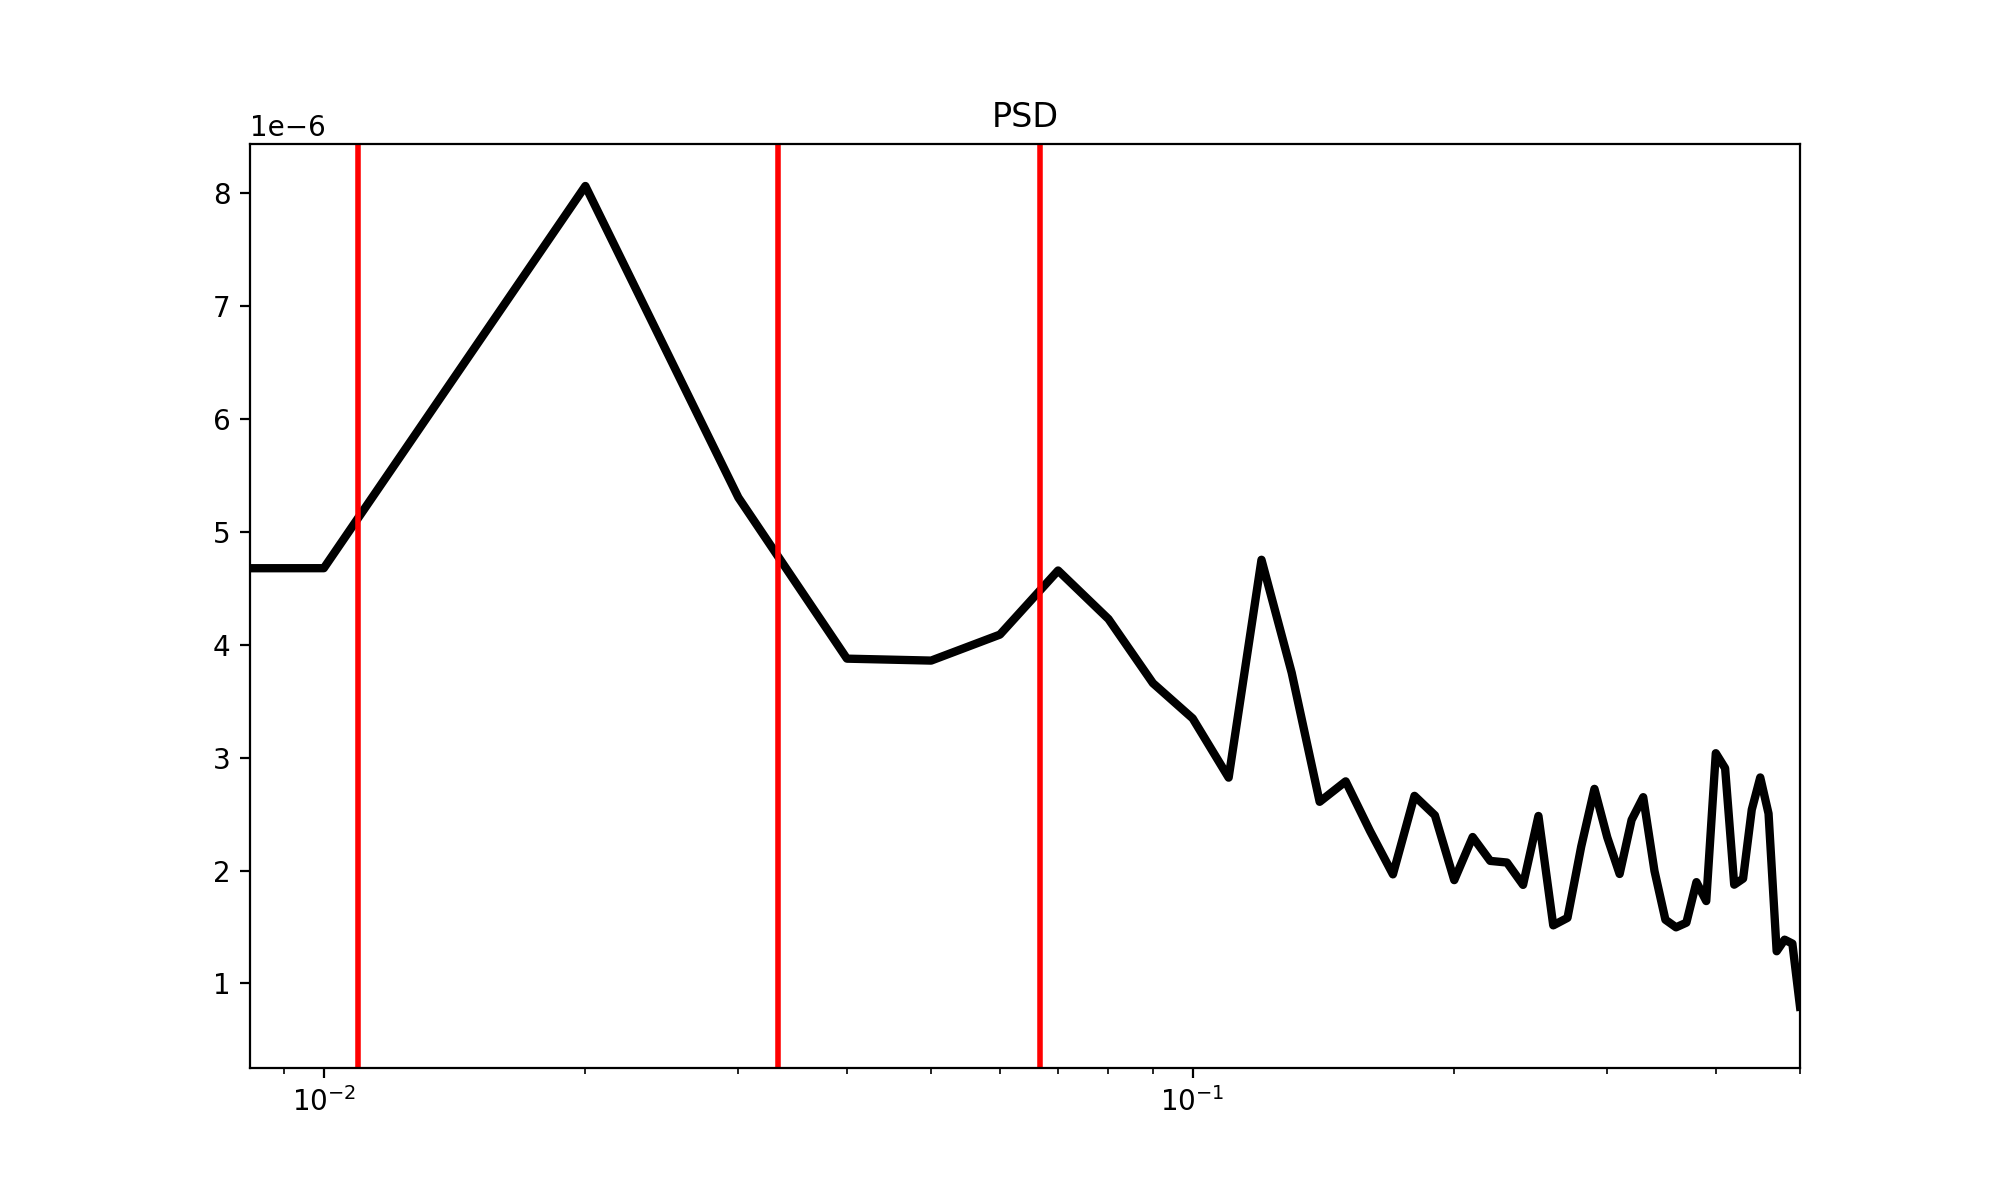

/var/folders/5b/myx79z857tg8sb66_xtdly7c0000gn/T/ipykernel_12005/2560273961.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0,0.5)


In [3]:
fig,ax = plt.subplots(1,1,figsize=(10, 6))
### Cumulative PSD
wT=0
R_ResidualsT=0
for i in range(len(R_Residuals)):
    f,  w = scipy.signal.welch(R_Residuals[i], fs=1,nperseg=100)
    R_ResidualsT+=R_Residuals[i]
    wT=wT+w

#f,  w = scipy.signal.welch(R_ResidualsT, fs=1,nperseg=50)
#wT=np.mean(wT)
ax.semilogx(f,w,color='k',linewidth=3)
ax.set_title('PSD')
ax.set_xlim(0,0.5)
ax.axvline(x=1/(365/2),color='r',linewidth=2,label=r' 1 year')
ax.axvline(x=1/(365/4),color='r',linewidth=2,label=r' 0.5 year')
ax.axvline(x=1/(60/2),color='r',linewidth=2,label=r' 60 days')
ax.axvline(x=1/(30/2),color='r',linewidth=2,label=r' 30 days')

### Plot the time-frequency representation of a random example

<IPython.core.display.Javascript object>


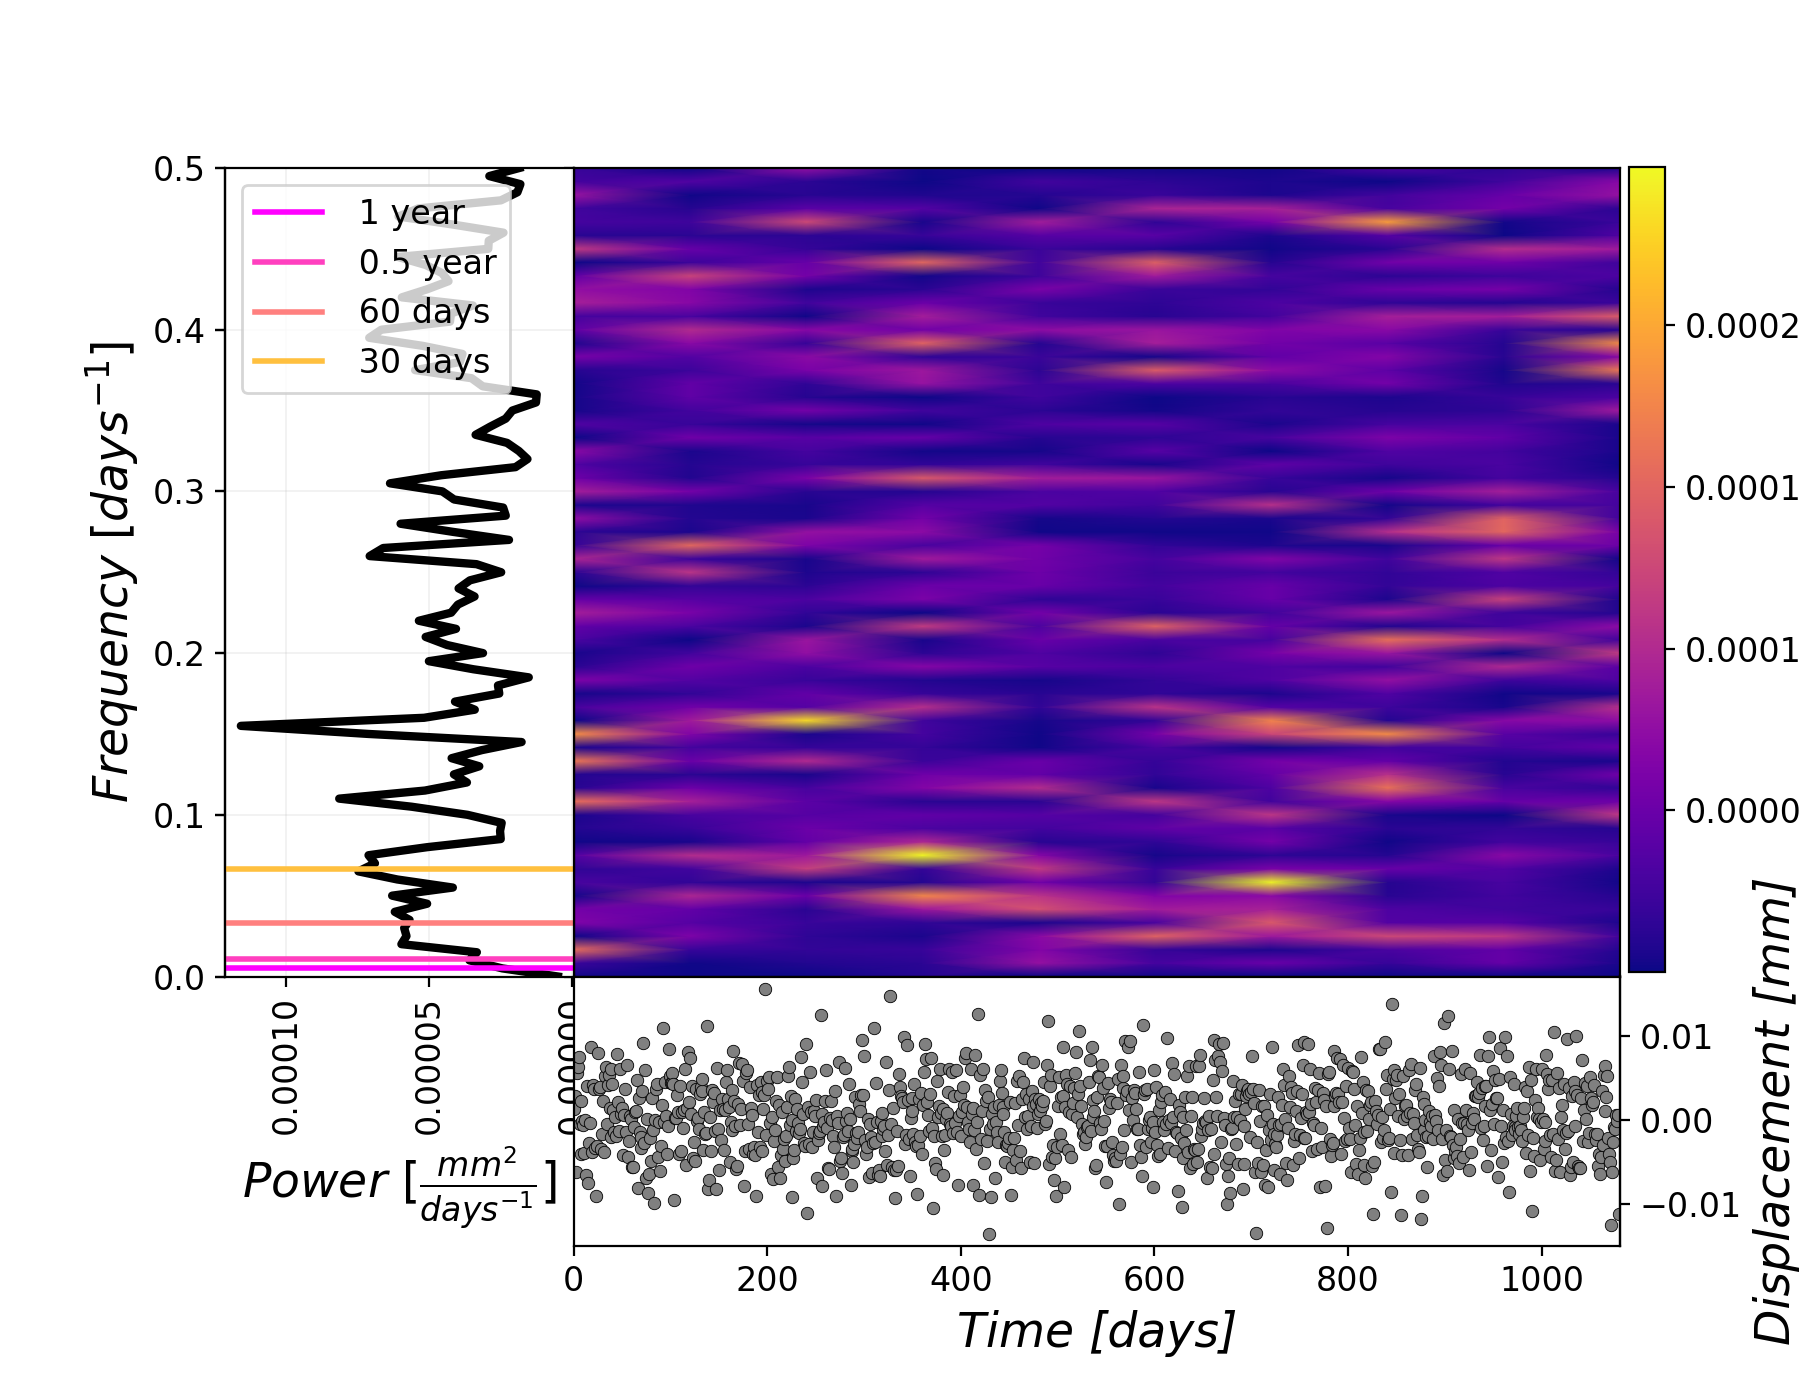

1081


In [8]:
sample=random.sample(range(len(R_Residuals)),k=1)[0]
Spectr=S_RT[sample]
original_shape=range(R_Residuals[0,:].shape[0])

save_flag=False
save_path='/home/giacomo/Documents/Synthetic_dataset/'
save_name='Random_Time_freq_rapresentation.pdf'
frequency_time_residuals(Spectr,original_shape,n_fftW,save_flag,save_name,save_path)

### Load GAN generated samples

In [53]:
Fake_SpectrogramsN=np.load('/Users/giacomo/Downloads/Generated_spectrograms/U_DEFINITIVO/U_GAN_residuals.npy')
print('Fake Spectrograms shape: ',Fake_SpectrogramsN.shape)

########### Random Shuffle ###########
idx = np.random.permutation(Fake_SpectrogramsN.shape[0])
Fake_SpectrogramsN=Fake_SpectrogramsN[idx]


Fake Spectrograms shape:  (20000, 48, 48, 1)


### Checking distributions by computing the PCA

We utilized various statistical tests to evaluate the quality of the generated data. For the generated samples to be considered reliable, they must meet both the diversity and fidelity criteria. This means that the generated data should have a distribution that encompasses the real data, while also being indistinguishable from it. The first test we applied is the application of the Principal Component Analysis (PCA) to synthetic and real datasets. The PCA is a linear dimensionality reduction algorithm that converts the data into a smaller new coordinate system preserving as much as feasible of the variability of the original data [Tipping and Bishop, 1999]. PCA is often used for image compression, a method exploited to reduce the size of an image while maintaining the highest possible level of the image's clarity. We here fit the PCA decomposition model to real spectrograms employing the first two components. This means that the real spectrograms are converted in a 2-D space represented by the directions of their maximum variance.  The obtained dimensionality reduction model is subsequently applied on the synthetic dataset as well as to a randomly generated dataset of white noise spectrograms.

In [26]:
############ Shuffle ############
sample_size = len(SxxI)
#idx = np.random.permutation(len(SxxI))[:sample_size]
#idx=list(np.arange(0,sample_size))
#SxxI = np.asarray(SxxI)[idx]
#S_RT = np.asarray(S_RT)[idx]

#idx = np.random.permutation(len(Fake_SpectrogramsN))[:]
#Fake_SpectrogramsN=np.squeeze(Fake_SpectrogramsN)
#Fake_SpectrogramsN=np.asarray(Fake_SpectrogramsN)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for the PCA
SxxI_reduced=np.array(np.squeeze(SxxI))
SxxI_reduced=SxxI_reduced.reshape((SxxI_reduced.shape[0],SxxI_reduced.shape[1]*SxxI_reduced.shape[2]))

Fake_Spectrograms_reduced=np.array(np.squeeze(Fake_SpectrogramsN))
Fake_Spectrograms_reduced=Fake_Spectrograms_reduced.reshape((Fake_Spectrograms_reduced.shape[0],Fake_Spectrograms_reduced.shape[1]*Fake_Spectrograms_reduced.shape[2]))

S_RT_reduced=np.array(np.squeeze(S_RT))
S_RT_reduced=S_RT_reduced.reshape((S_RT_reduced.shape[0],S_RT_reduced.shape[1]*S_RT_reduced.shape[2]))

############ PCA ############
n_components = 2
pca = PCA(n_components=n_components)

#The fit of the methods must be done only using the real sequential data
pca.fit(SxxI_reduced)

pca_real = pd.DataFrame(pca.transform(SxxI_reduced))
pca_random= pd.DataFrame(pca.transform(S_RT_reduced)) 
pca_synth= pd.DataFrame(pca.transform(Fake_Spectrograms_reduced)) 

/Users/giacomo/opt/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/giacomo/opt/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


#### Plot PCA

<IPython.core.display.Javascript object>


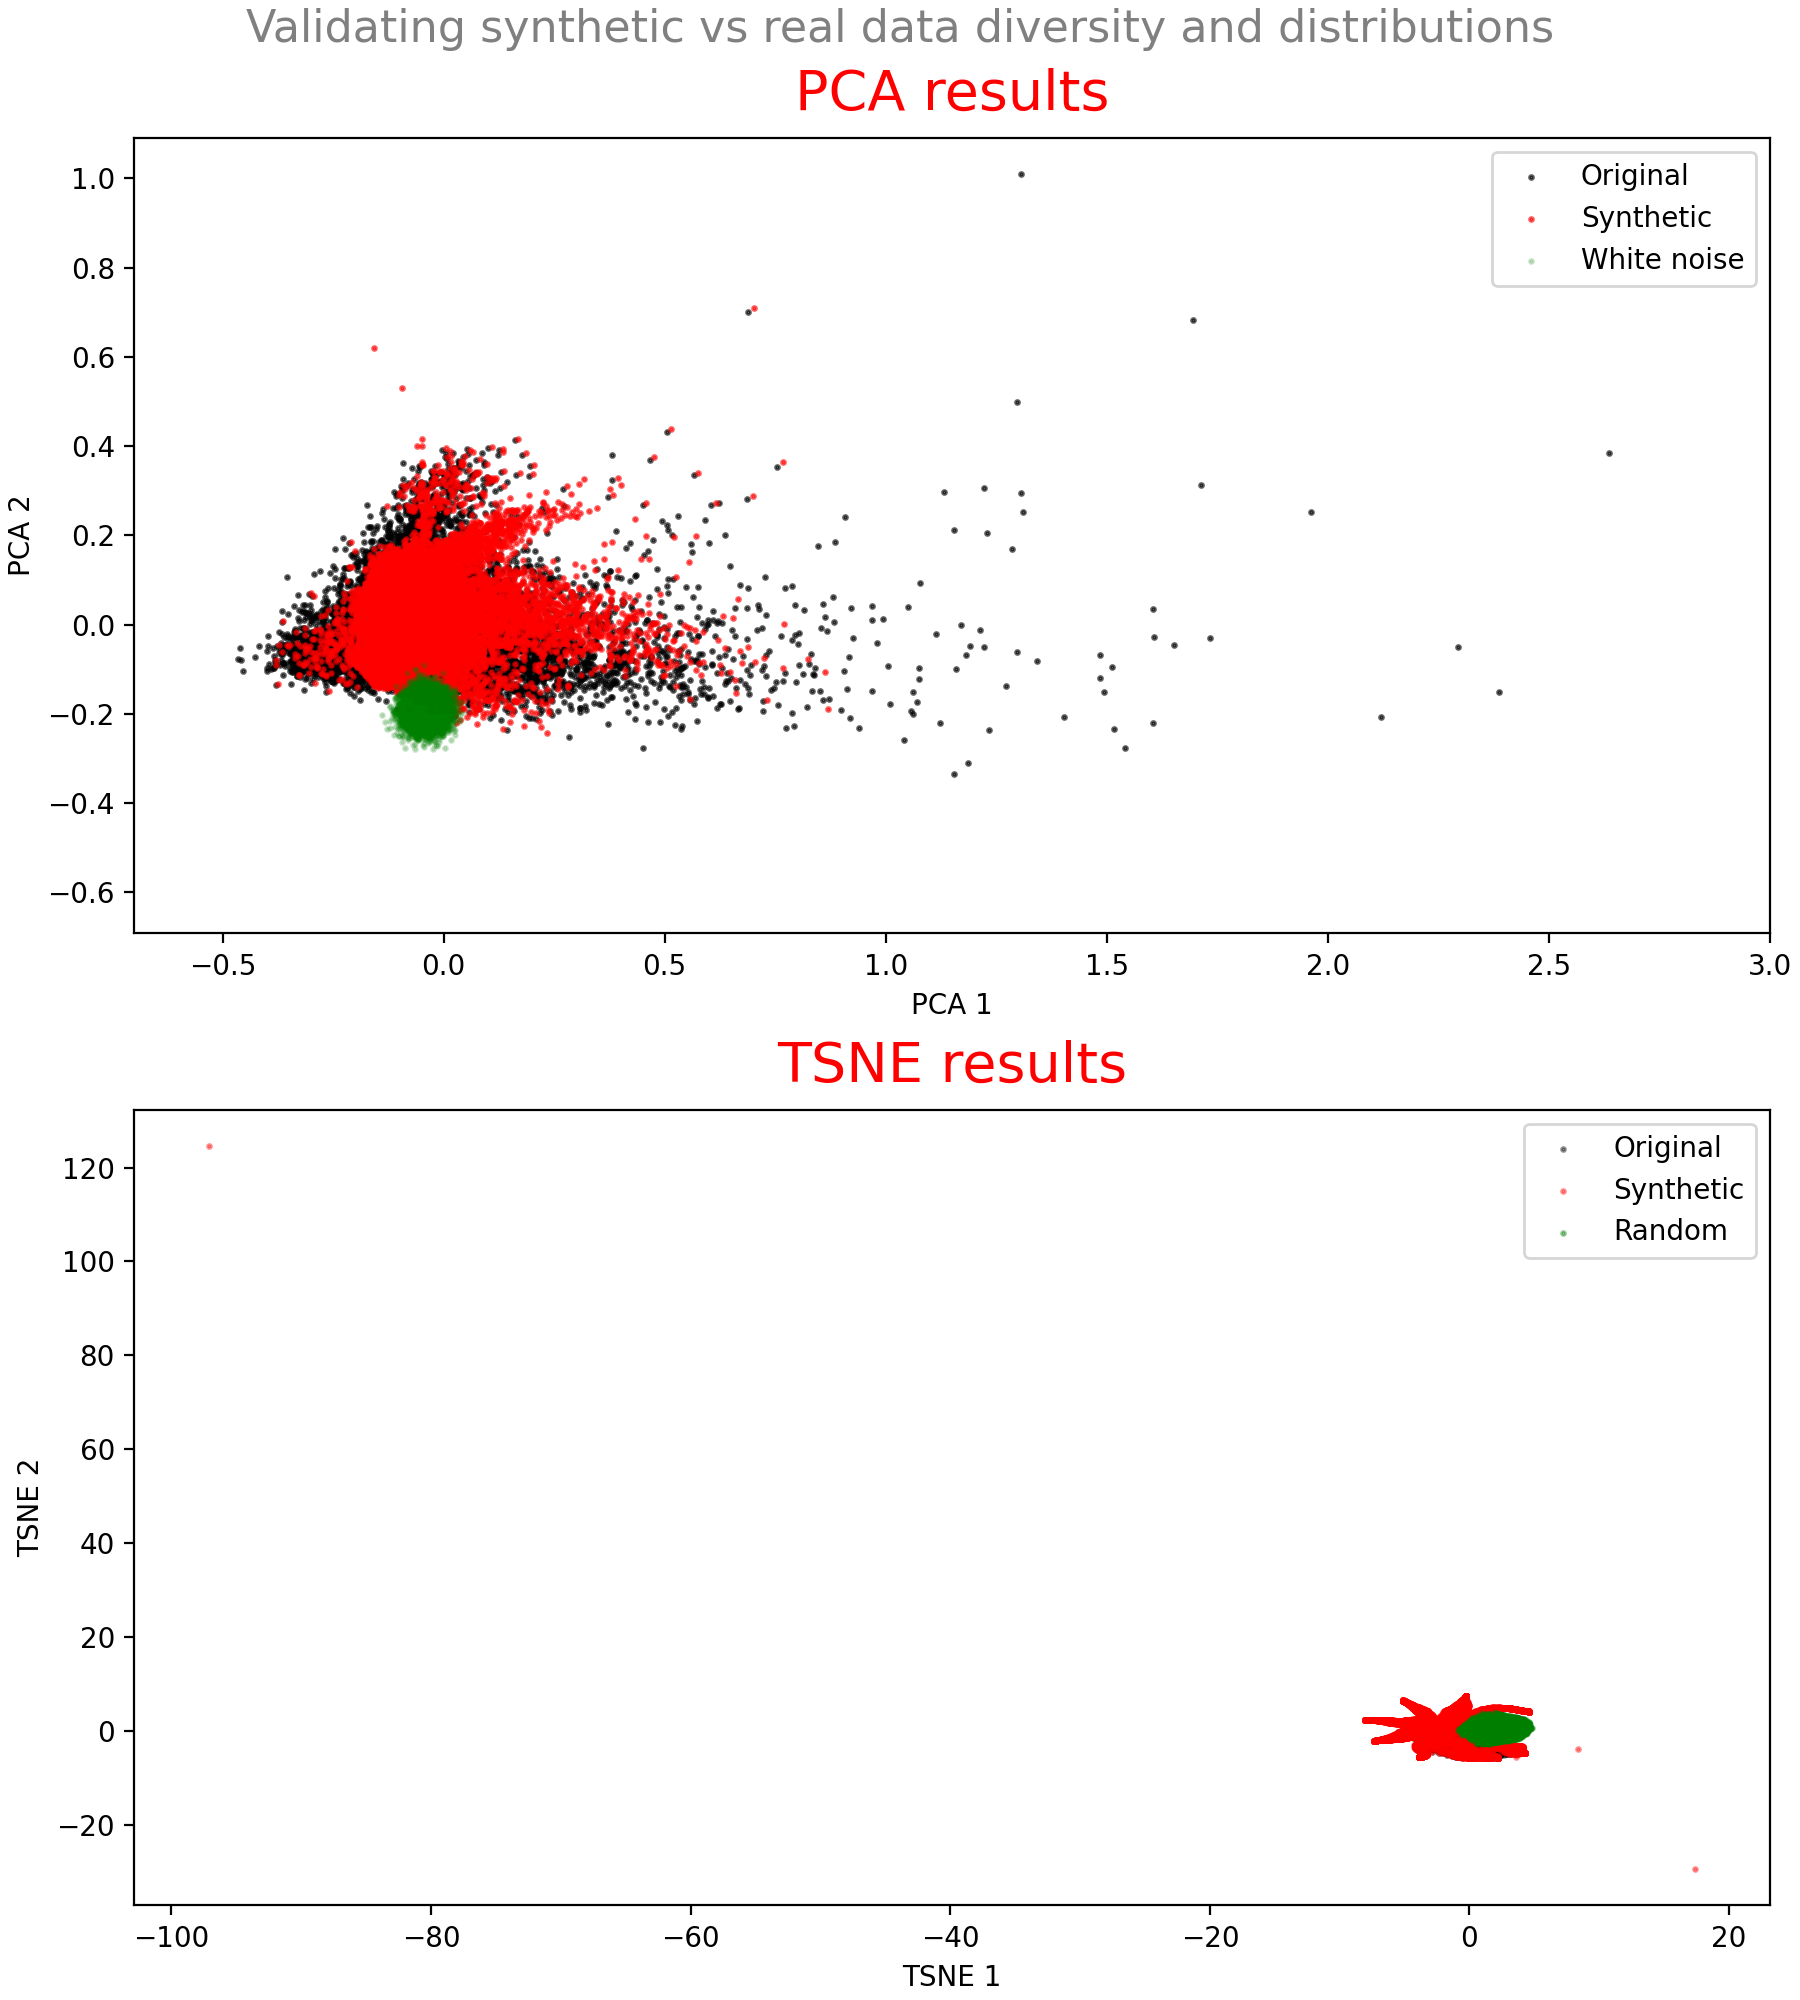

In [29]:
#The scatter plots for PCA 
fig = plt.figure(constrained_layout=True, figsize=(9,10))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,s=2,
            c='black', alpha=0.6, label='Original')
quali=np.array(np.argwhere(pca_real.iloc[:, 0].values < -0.0115)[:,0])
#PCA scatter plot
#plt.scatter(pca_real.iloc[quali, 0].values, pca_real.iloc[quali,1].values,s=2,c='orange', alpha=0.6, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],s=2,c='red', alpha=0.6, label='Synthetic')

plt.scatter(pca_random.iloc[:,0], pca_random.iloc[:,1],s=2,c='green', alpha=0.2, label='White noise')
#ax.set_xlim(-0.2,0.7)
#ax.set_ylim(-0.15,0.2)
ax.legend()
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_xlim([-0.7,3])


fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

plt.savefig('/Users/giacomo/Documents/PhD/Papers/GNSS_DENOISER/PCA_GAN_U.pdf')

### CLASSIFY DATA BY USING CNN

To quantitatively assess the similarity and fidelity between the original and generated datasets, we trained three post-hoc classification models using 3-layer CNNs in a standard supervised framework [e.g. Yoon, et al., 2019]. These models were designed to differentiate between spectrograms from the original dataset and those generated by the GAN. The first classification model was trained by labeling real data as "real" and white noise as "fake." It was then tested on GAN-generated spectrograms as well as different examples of white noise. Conversely, the second model was trained to label GAN-generated data as "real" and white noise as "fake," and its testing focused on classifying real spectrograms as "real" and different white noise examples as "fake". Lastly, the third CNN model was trained to classify real spectrograms as "real" and generated samples as "fake". To evaluate the performance of each model, we calculated the classification error using held-out test sets. This provided a quantitative measure of the effectiveness of our generative model. 


#### Load Fake data again

In [34]:
Fake_Spectrograms=np.load('/Users/giacomo/Downloads/Generated_spectrograms/U_DEFINITIVO/U_GAN_residuals.npy')  

#### Prepare datasets

In [47]:
############ Real data ############
#Fake_Spectrograms=np.squeeze(Fake_Spectrograms)

X=np.concatenate([SxxI,S_RT])
target_namesR=np.zeros(SxxI.shape[0])
target_namesF=np.ones(int(S_RT.shape[0]))
y=np.concatenate([target_namesR,target_namesF])

idx = np.random.permutation(X.shape[0])
X= X[idx]
y = y[idx]
X=np.expand_dims(X, axis=2)
print('Real X train: {}'.format(X.shape))
print('Real Y train: {}'.format(y.shape))
num_classes = len(np.unique(y))
print('Num classes: {}'.format(num_classes))

idx = np.random.permutation(SxxI.shape[0])
Fake_SpectrogramsN=Fake_Spectrograms[idx]

############ Synthetic data ############
X_synth=np.squeeze(Fake_SpectrogramsN)
X2=np.concatenate([X_synth,S_RT2])
target_namesR=np.zeros(X_synth.shape[0])
target_namesF=np.ones(int(S_RT2.shape[0]))
y2=np.concatenate([target_namesR,target_namesF])

idx = np.random.permutation(X2.shape[0])
X2 = X2[idx]
y2 = y2[idx]
X2=np.expand_dims(X2, axis=2)
print('Real X train: {}'.format(X2.shape))
print('Real Y train: {}'.format(y2.shape))
num_classes = len(np.unique(y2))
print('Num classes: {}'.format(num_classes))

###### Synthetic-Real data ######
half=int(Fake_SpectrogramsN.shape[0]/2)
X_synth_half=np.squeeze(Fake_SpectrogramsN[:half])
SxxI_half=SxxI[:half]
X3=np.concatenate([X_synth_half,SxxI_half])
target_namesR=np.zeros(X_synth_half.shape[0])
target_namesF=np.ones(int(SxxI_half.shape[0]))
y3=np.concatenate([target_namesR,target_namesF])

###### Synthetic-Real data #####
X_synth_half2=np.squeeze(Fake_SpectrogramsN[half:])
SxxI_half2=SxxI[half:]
X4=np.concatenate([X_synth_half2,SxxI_half2])
target_namesR=np.zeros(X_synth_half2.shape[0])
target_namesF=np.ones(int(SxxI_half2.shape[0]))
y4=np.concatenate([target_namesR,target_namesF])

idx = np.random.permutation(X3.shape[0])
X3 = X3[idx]
y3 = y3[idx]
X3=np.expand_dims(X3, axis=2)
X4=np.expand_dims(X4, axis=2)
print('Real X train: {}'.format(X3.shape))
print('Real Y train: {}'.format(y3.shape))
num_classes = len(np.unique(y3))
print('Num classes: {}'.format(num_classes))


Real X train: (16140, 48, 1, 48)
Real Y train: (16140,)
Num classes: 2
Real X train: (16140, 48, 1, 48)
Real Y train: (16140,)
Num classes: 2
Real X train: (8070, 48, 1, 48)
Real Y train: (8070,)
Num classes: 2


#### Build the CNN

In [37]:
##### from tensorflow.keras import Input, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense,LSTM,Flatten,Conv2D,BatchNormalization,ReLU,GlobalAveragePooling2D,Input
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import optimizers

def CNN(input_shape,num_classes):
    input_layer = Input(shape=input_shape)

    conv1 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv2D(32, (5, 5), strides=(2, 2), padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling2D()(conv3)

    output_layer = Dense(num_classes, activation="softmax")(gap)

    return Model(inputs=input_layer, outputs=output_layer)

class CustomCallback(tf.keras.callbacks.Callback,thr):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_sparse_categorical_accuracy') >thr:  #0.0190 predicting the original
            self.model.stop_training = True

In [38]:
################ REAL + NOISE FOR TRAINING ################
ts_real = CNN(input_shape=X.shape[1:],num_classes=num_classes)
ts_real.compile(optimizer=optimizers.Adam(learning_rate=5e-4),loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])


thr=0.95           
callbackThr = CustomCallback(thr)
#ts_real = RNN_regression(100)
ts_real.summary()
#Training the model with the real train data
earlystopper = EarlyStopping(
    monitor='val_sparse_categorical_accuracy', patience=50, verbose=0, mode='auto')

real_train = ts_real.fit(x=X,
                          y=y,validation_data=(X2,y2),
                          epochs=150,
                          batch_size=256,
                          callbacks=[earlystopper,callbackThr])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 1, 48)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 1, 128)        153728    
                                                                 
 batch_normalization (BatchN  (None, 24, 1, 128)       512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 24, 1, 128)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 1, 64)         204864    
                                                                 
 batch_normalization_1 (Batc  (None, 12, 1, 64)        256       
 hNormalization)                                             

64/64 [==============================] - 4s 59ms/step - loss: 2.0660e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3545 - val_sparse_categorical_accuracy: 0.9170
Epoch 78/150
64/64 [==============================] - 4s 60ms/step - loss: 1.9456e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3746 - val_sparse_categorical_accuracy: 0.9147
Epoch 79/150
64/64 [==============================] - 4s 60ms/step - loss: 1.7058e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3826 - val_sparse_categorical_accuracy: 0.9139
Epoch 80/150
64/64 [==============================] - 4s 60ms/step - loss: 5.7805e-04 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.2295 - val_sparse_categorical_accuracy: 0.9366
Epoch 81/150
64/64 [==============================] - 4s 60ms/step - loss: 0.0041 - sparse_categorical_accuracy: 0.9991 - val_loss: 2.7841 - val_sparse_categorical_accuracy: 0.5314
Epoch 82/150
64/64 [==============================] - 4s 60ms/step - loss: 0.0082 - sparse_c

In [44]:
################ SYNTH + NOISE FOR TRAINING ################
ts_synth = CNN(input_shape=X2.shape[1:],num_classes=num_classes)
ts_synth.compile(optimizer=optimizers.Adam(learning_rate=5e-4),loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])

#ts_synth = RNN_regression(100)
ts_synth.summary()
#Training the model with the real train data
earlystopper = EarlyStopping(
    monitor='val_loss', patience=60, verbose=0, mode='auto')

callbackThr = CustomCallback(thr)           
synth_train = ts_synth.fit(x=X2,
                          y=y2,validation_data=(X,y),
                          epochs=100,
                          batch_size=128,
                          callbacks=[earlystopper,callbackThr])


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 1, 48)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 1, 128)        153728    
                                                                 
 batch_normalization_18 (Bat  (None, 24, 1, 128)       512       
 chNormalization)                                                
                                                                 
 re_lu_18 (ReLU)             (None, 24, 1, 128)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 12, 1, 64)         204864    
                                                                 
 batch_normalization_19 (Bat  (None, 12, 1, 64)        256       
 chNormalization)                                          

In [48]:
################ SYNTH + NOISE FOR TRAINING ################
ts_real_synth = CNN(input_shape=X3.shape[1:],num_classes=num_classes)
ts_real_synth.compile(optimizer=optimizers.Adam(learning_rate=5e-5),loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])

#ts_synth = RNN_regression(100)
ts_real_synth.summary()
#Training the model with the real train data
earlystopper = EarlyStopping(
    monitor='val_loss', patience=50, verbose=0, mode='auto')

real_synth_train = ts_real_synth.fit(x=X3,
                          y=y3,validation_data=(X4,y4),
                          epochs=2,
                          batch_size=128,
                          callbacks=[earlystopper])

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 48, 1, 48)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 24, 1, 128)        153728    
                                                                 
 batch_normalization_24 (Bat  (None, 24, 1, 128)       512       
 chNormalization)                                                
                                                                 
 re_lu_24 (ReLU)             (None, 24, 1, 128)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 12, 1, 64)         204864    
                                                                 
 batch_normalization_25 (Bat  (None, 12, 1, 64)        256       
 chNormalization)                                          

### Plot Learning curves

<IPython.core.display.Javascript object>


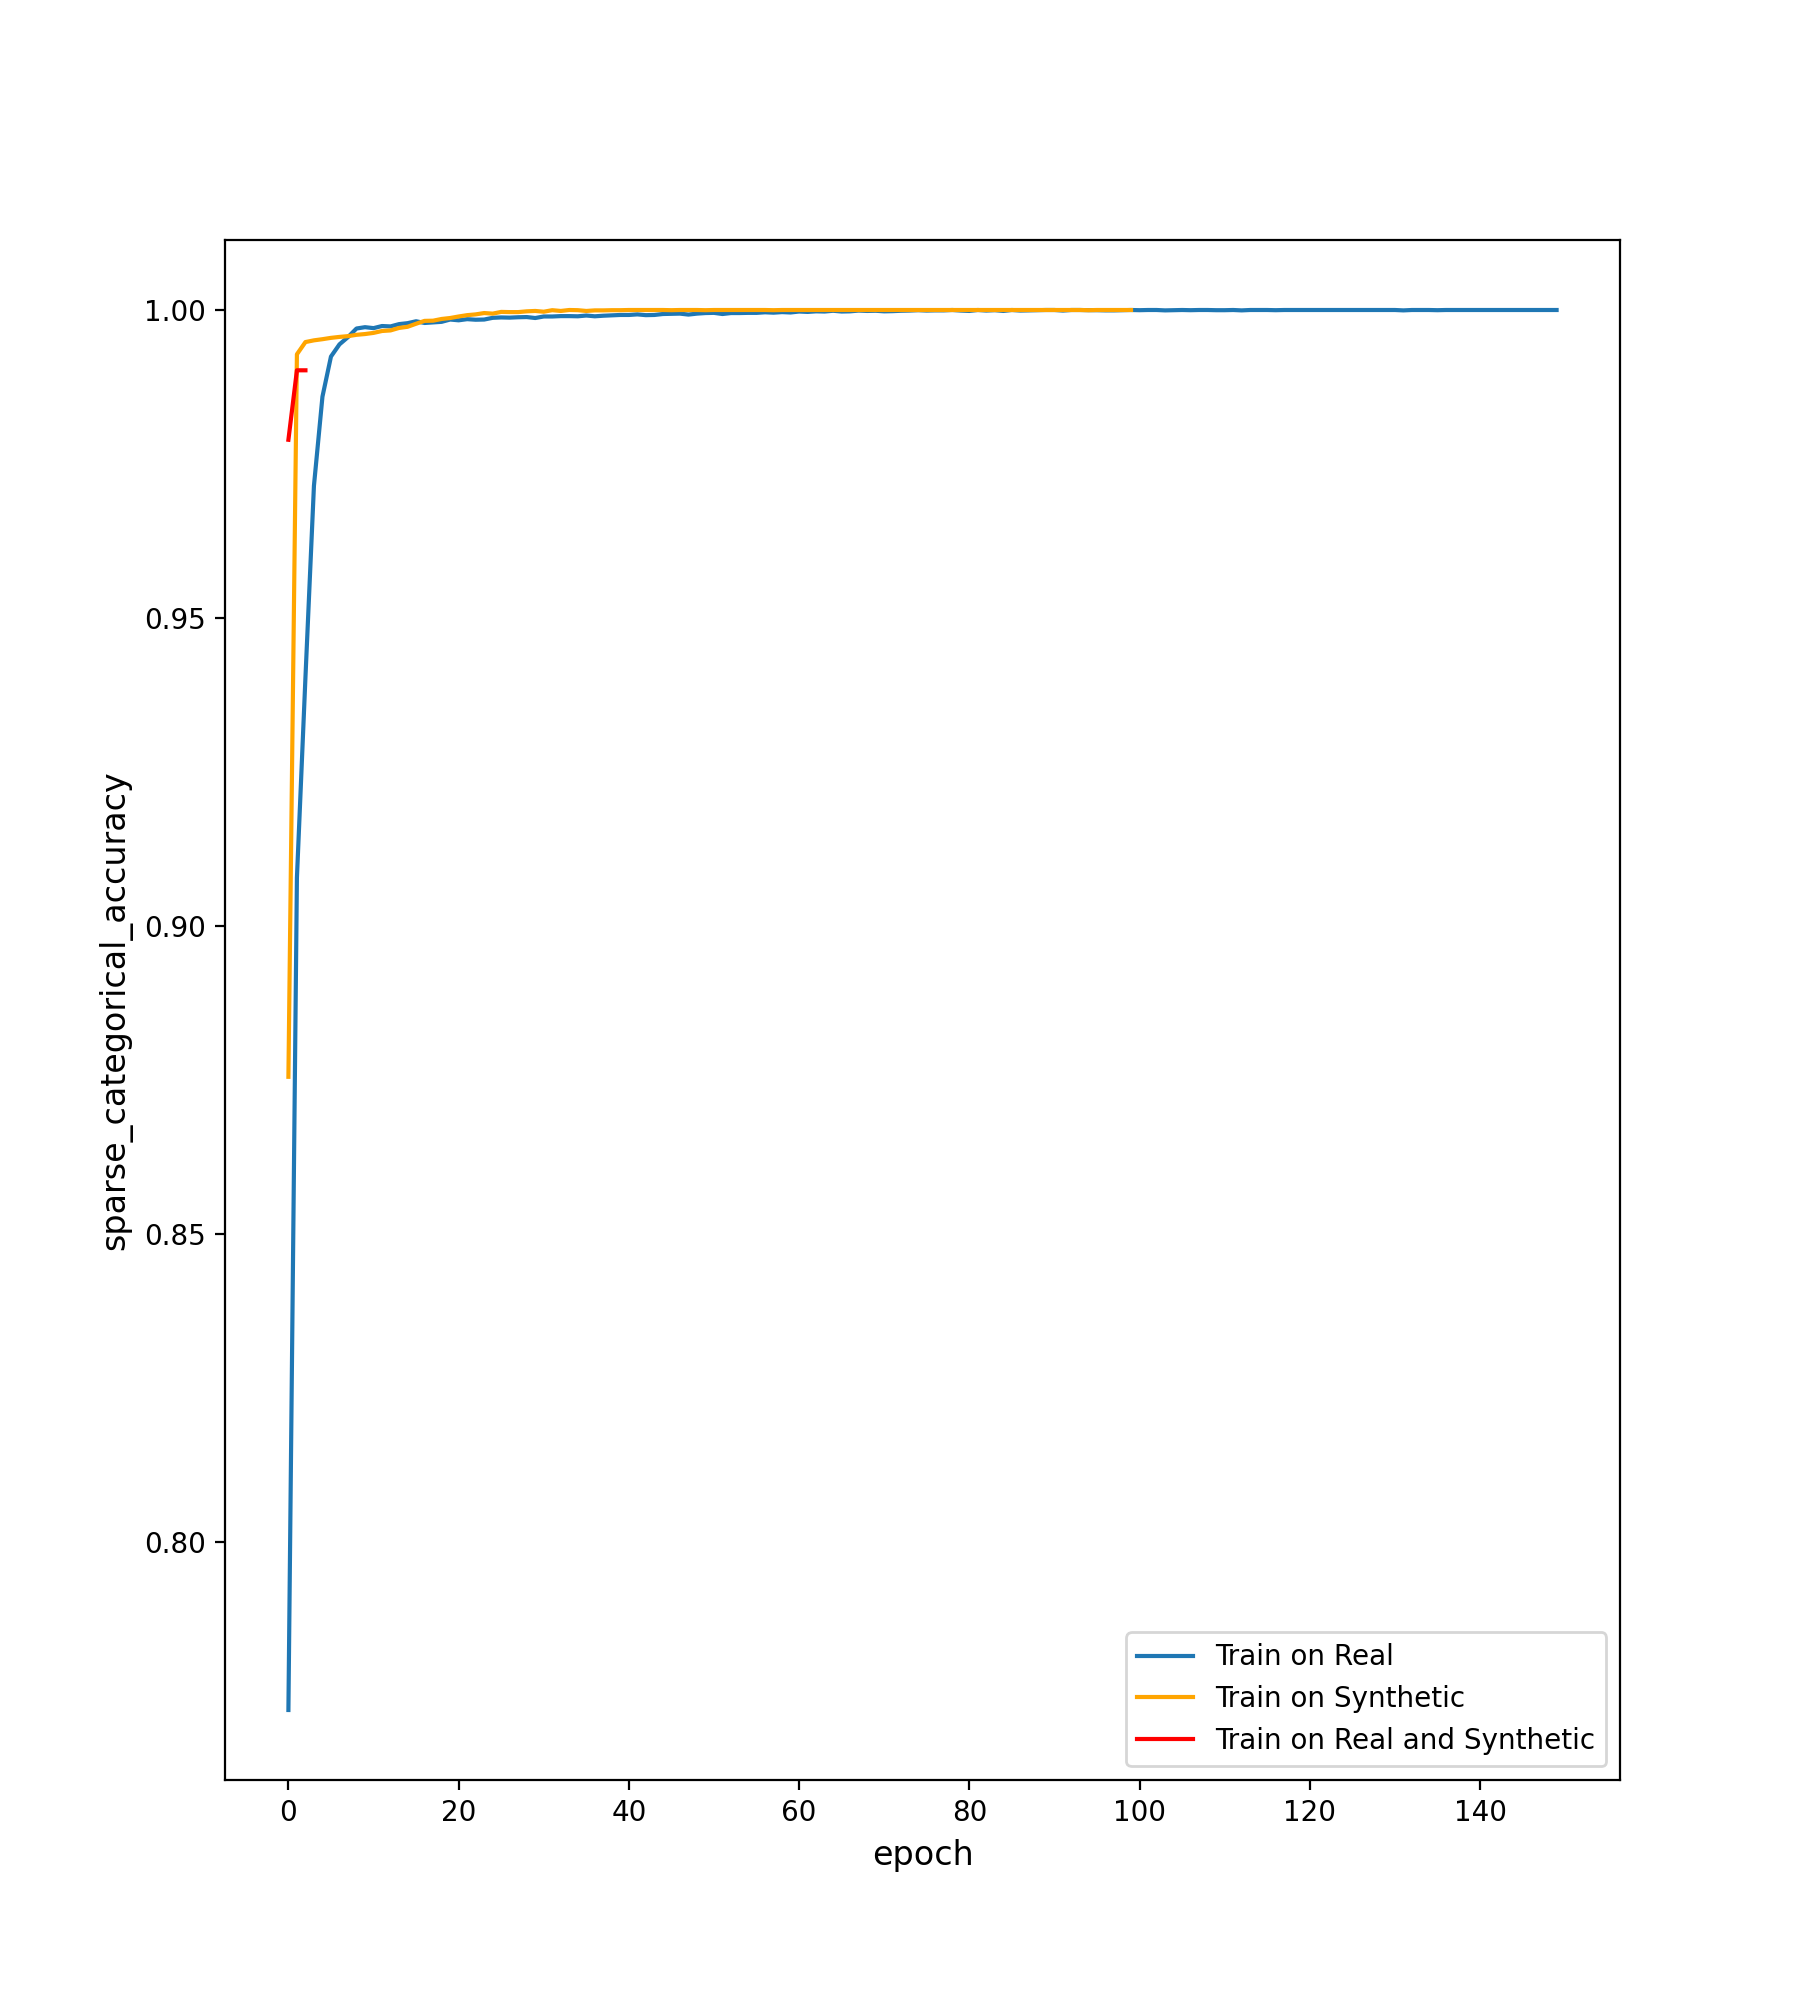

In [291]:
metric = "sparse_categorical_accuracy"
fig,axes=plt.subplots(1,1,figsize=(9,10))

axes.plot(real_train.history[metric],label='Train on Real')
axes.plot(synth_train.history[metric],color='orange',label='Train on Synthetic')
axes.plot(real_synth_train.history[metric],color='red',label='Train on Real and Synthetic')
axes.set_ylabel(metric, fontsize="large")
axes.set_xlabel("epoch", fontsize="large")
axes.legend(loc="best")

plt.show()

### Summarize the results here as a pandas dataframe

In [49]:

import pandas as pd
from sklearn.metrics import accuracy_score
metrics_dict = {"Test accuracy": [ts_real.evaluate(X2, y2)[1],
                       ts_synth.evaluate(X, y)[1],ts_real_synth.evaluate(X4, y4)[1]]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic','Real and Synthetic'])

results

253/253 [==============================] - 1s 4ms/step - loss: 0.6972 - sparse_categorical_accuracy: 0.5000


,Test accuracy
Real,0.908984
Synthetic,0.959108
Real and Synthetic,0.500000


### Compute confusion matrices

In [50]:
y_pred=ts_real.predict(X2)
y_preds = np.where(y_pred[:,1] > 0.5, 1, 0)
cmTR = confusion_matrix(y2, y_preds, normalize='all')
y_pred=ts_synth.predict(X)
y_preds = np.where( y_pred[:,1] > 0.5, 1, 0)
cmTRS= confusion_matrix(y, y_preds, normalize='all')
y_pred=ts_real_synth.predict(X4)
y_preds = np.where( y_pred[:,1] > 0.9, 1, 0)
cmTRTS= confusion_matrix(y3, y_preds, normalize='all')
labels=[['GAN-generated','White noise'],['Real data','White noise'],['Real data','GAN-generated']]
import numpy as np
cm_list=[cmTR,cmTRS,cmTRTS]

253/253 [==============================] - 1s 3ms/step


#### Plot confusion matrices

<IPython.core.display.Javascript object>


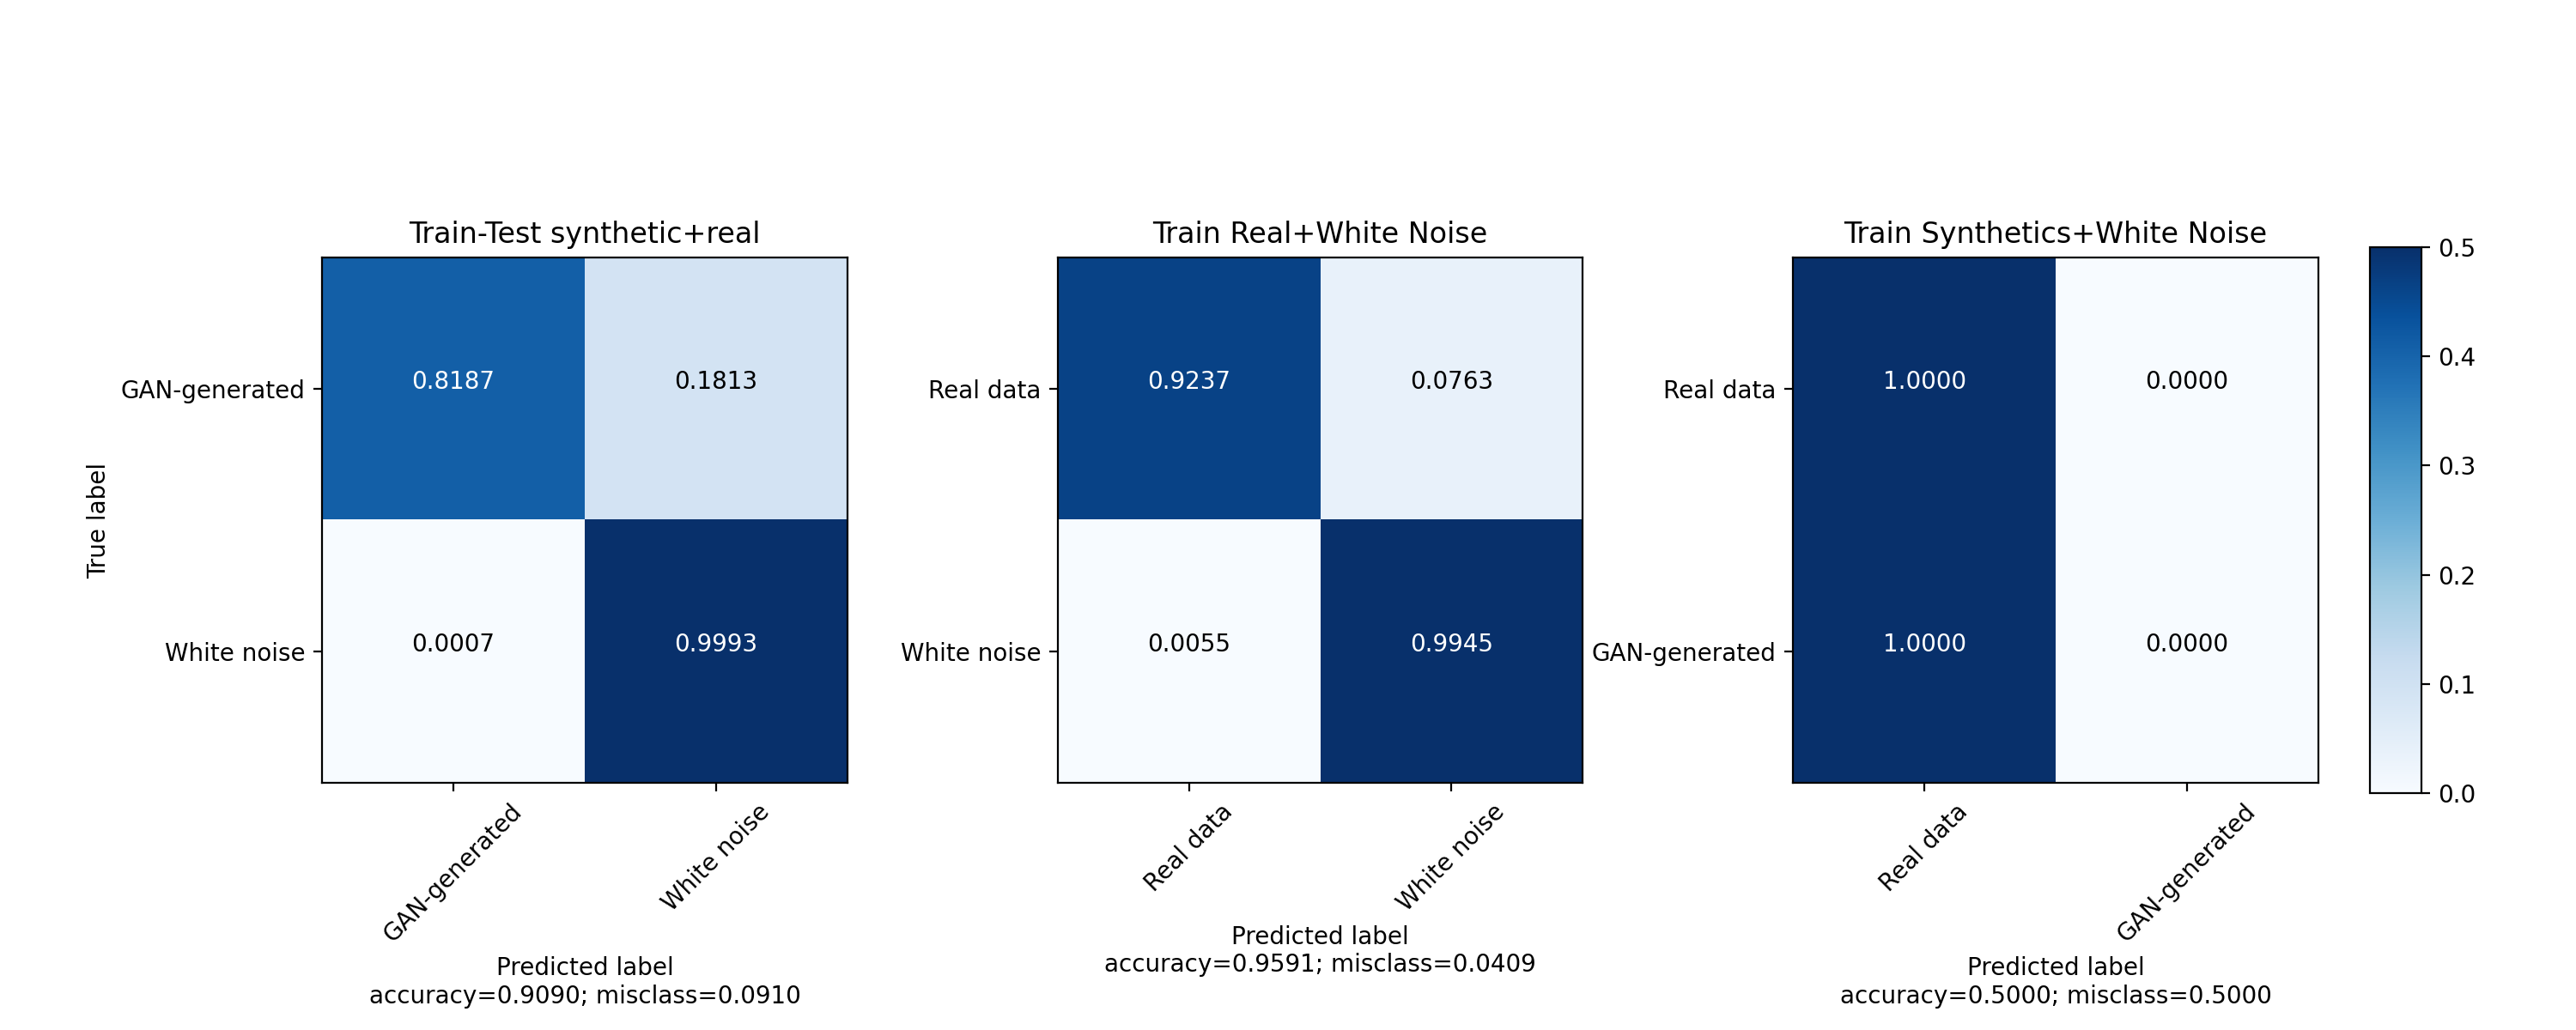

In [51]:
titles=['Train-Test synthetic+real','Train Real+White Noise','Train Synthetics+White Noise']
plot_confusion_matrix(cm_list,
                          labels,
                          title=titles,
                          cmap=None,
                          normalize=True)

#plt.savefig('/Users/giacomo/Documents/PhD/Papers/GNSS_DENOISER/Classification_test_U_Resudals.pdf')